## Libraries

In [1]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import shap

## Data Manipulation

In [2]:
mode_allcat = pd.read_csv("mode_allcat.csv")
mode_ordinal = pd.read_csv("mode_ordinal.csv")
nan_allcat = pd.read_csv("nan_allcat.csv")

In [3]:
# change column name for xgboost
mode_allcat = mode_allcat.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})
mode_ordinal = mode_ordinal.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})
nan_allcat = nan_allcat.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})

## Modeling

Grid search iterative parameter search below. Best performing parameters are: 

-    "eta":[.3],
-    "gamma":[1],
-    "max_depth":[7],
-    "lambda":[0],
-    "alpha":[1],
     

### XGBoost

Data 1 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=5,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 1) = 0.8385499901069966


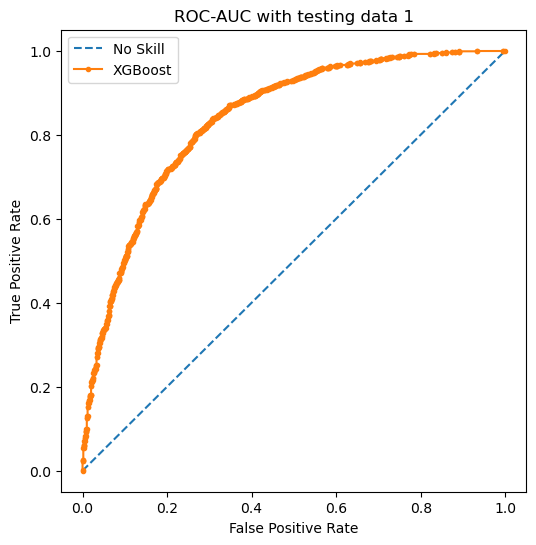

Data 2 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 2) = 0.8392263290869519


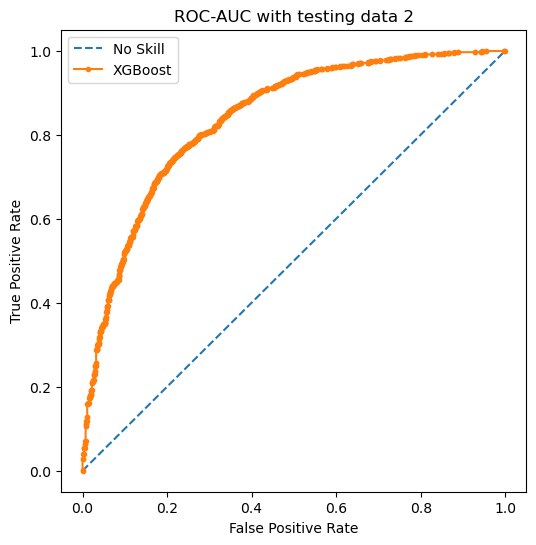

Data 3 best param: XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=5,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 3) = 0.8391445215591373


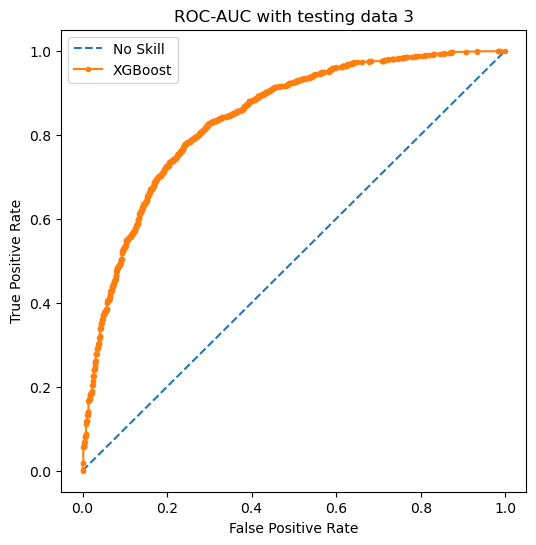

In [7]:
# param to search
xgb_param = {
    "eta":[0,.1,.3,.9,1],
    
    "gamma":[0,1,5],
    "max_depth":[8,7,6],
    
    "lambda":[0,1,5],
    "alpha":[0,1,5],
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    xgb = GridSearchCV(XGBClassifier(random_state=7), xgb_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    xgb.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {xgb.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = xgb.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Data 1 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 1) = 0.8370435266781325


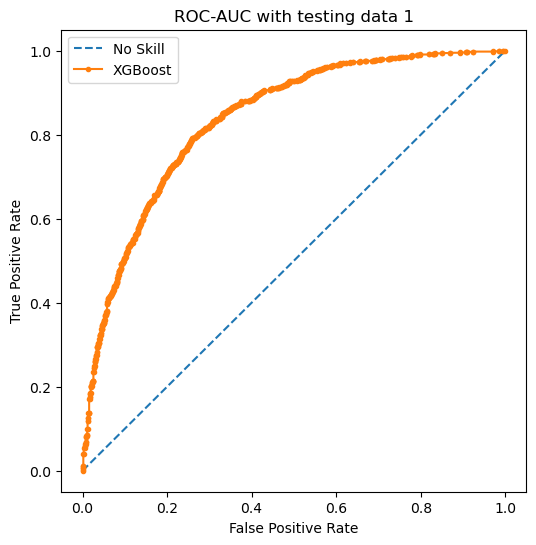

Data 2 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 2) = 0.8392263290869519


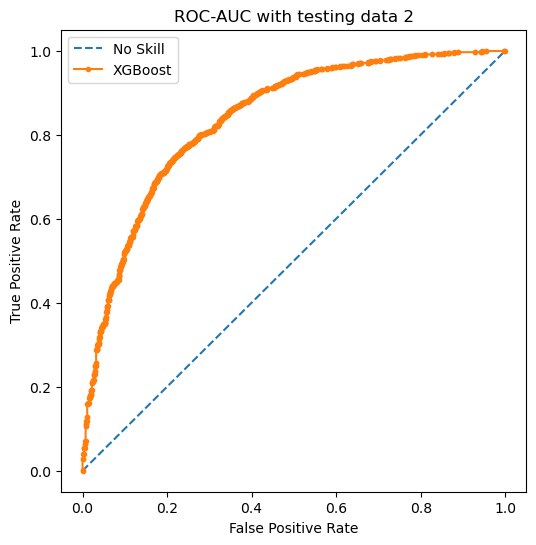

Data 3 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 3) = 0.8337724938993145


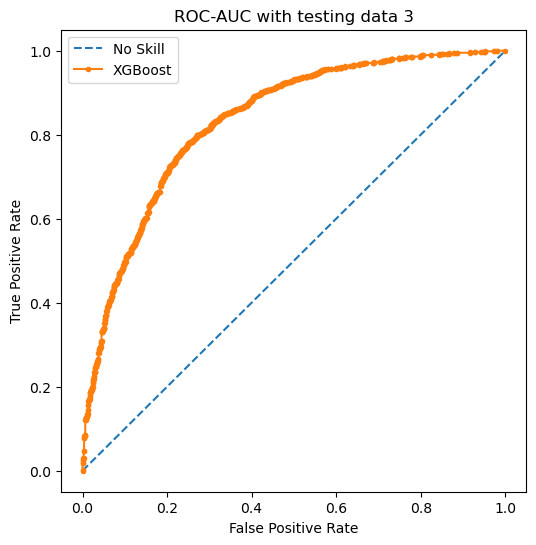

In [9]:
# param to search
xgb_param = {
    "eta":[.3],
    
    "gamma":[0,1],
    "max_depth":[9,8,7,6],
    
    "lambda":[0],
    "alpha":[0,1],
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    xgb = GridSearchCV(XGBClassifier(random_state=7), xgb_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    xgb.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {xgb.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = xgb.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6bbc1f14502746e0846459a92a67a764/11335-140591394488720-7152f487237d4b8fa145dc82fb12df3a.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

Data 1 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 1) = 0.8400222085242175


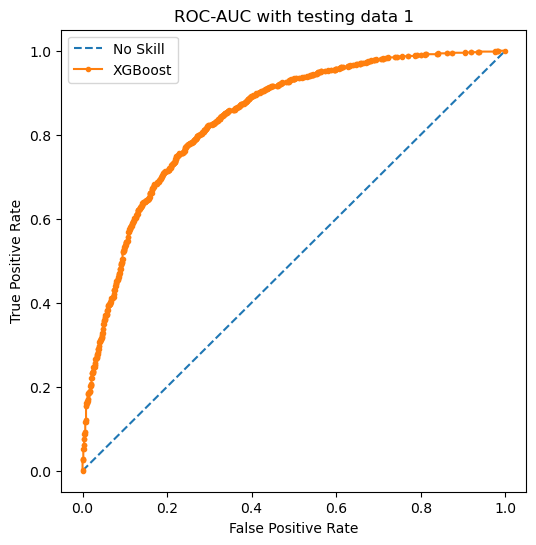

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_0853974bdd2e475682817de57cd0d32d/11335-140591394488720-23aa600ab6c949399f0e849420a3fe9f.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

Data 2 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 2) = 0.8392263290869519


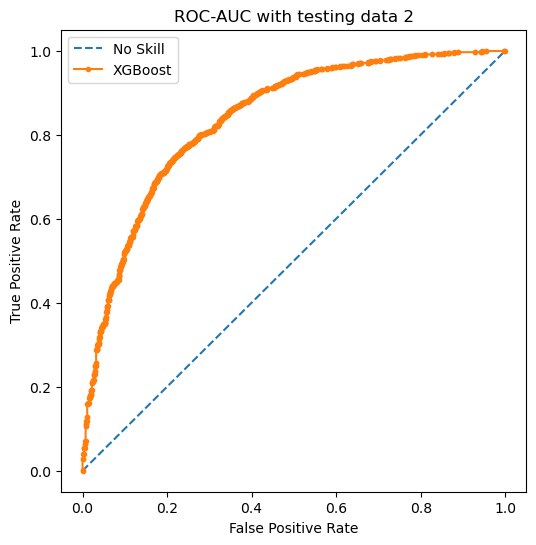

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_605cc1c1762748babcf875381cd4accd/11335-140591394488720-e152694e6b294a28a7ff7a58392fa5e3.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

Data 3 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 3) = 0.8352735669096794


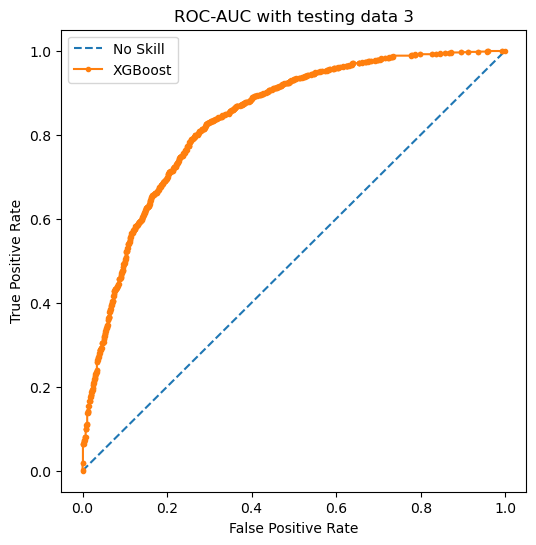

In [11]:
# param to search
xgb_param = {
    "eta":[.3],
    
    "gamma":[0,1,],
    "max_depth":[8,7,6,5,4],
    
    "lambda":[0,0.01,0.1,1],
    "alpha":[0,0.01,0.1,1],
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    xgb = GridSearchCV(XGBClassifier(random_state=7), xgb_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    xgb.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {xgb.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = xgb.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Data 1 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 1) = 0.8400222085242175


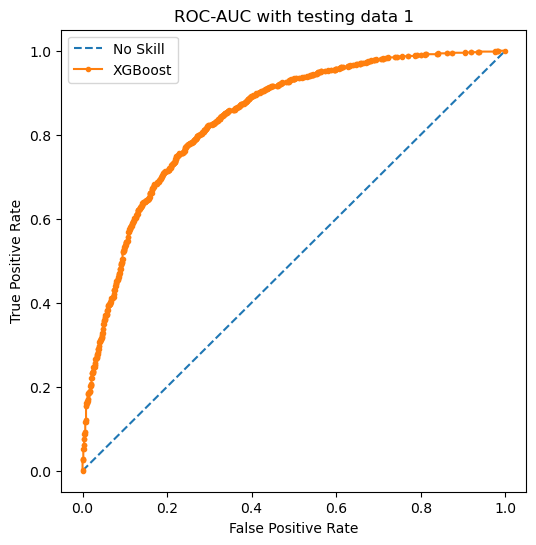

Data 2 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 2) = 0.8392263290869519


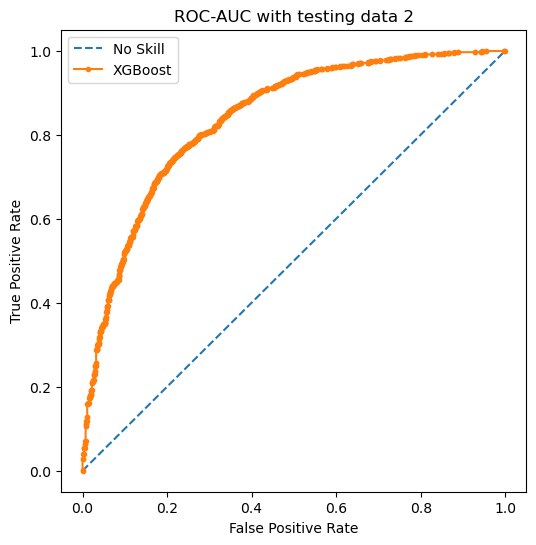

Data 3 best param: XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)
Model AUC (with data 3) = 0.8352735669096794


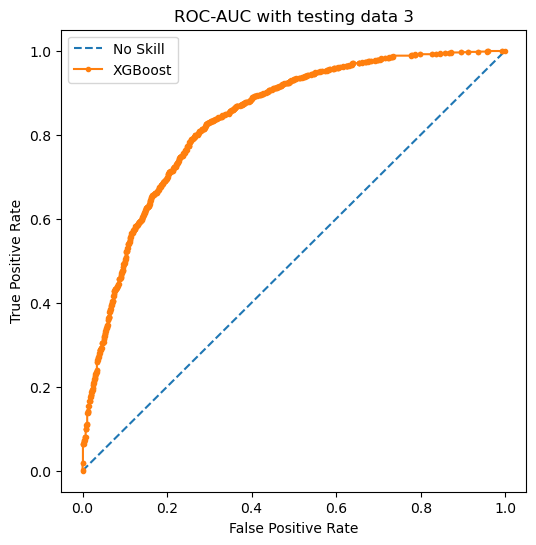

In [10]:
# param to search
xgb_param = {
    "eta":[.3],
    
    "gamma":[1],
    "max_depth":[7],
    
    "lambda":[0],
    "alpha":[1],
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    xgb = GridSearchCV(XGBClassifier(random_state=7), xgb_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    xgb.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {xgb.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = xgb.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()